Use conda environment `conda_envs/hic_nikita.yml` to run this notebook.

In [1]:
import sys
sys.path.append('scripts')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype

# Some additional for plots
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import cooler # Hi-C data processing
import networkx as nx # Network analysis
import pingouin as pg # Statistics

from sklearn.cluster import KMeans

# Some utils for notebook
from tqdm import tqdm
from IPython.display import display

# Custom
from my_loops_module import *
from my_network_utils import *

/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [6]:
from pandas.api.types import CategoricalDtype

chroms = Chromosome.chromosomes
regions_groups = {
    'Basal Nuclei': ['AMY', 'CMN', 'CaB', 'GPe', 'BNST', 'NAC', 'Pu'],
    'Basal Forebrain': ['SI', 'SEP'],
    'Cerebral cortex': ['MTG', 'LEC', 'A24', 'A46', 'FI', 'M1C', 'V1C', 'Pir']
}

regions_order = [reg for regs in regions_groups.values() for reg in regs]
reg_type = CategoricalDtype(categories=regions_order, ordered=True)
ct_type = CategoricalDtype(categories=['EN' , 'IN', 'NN'], ordered=True)
chr_type = CategoricalDtype(categories=chroms, ordered=True)


ct_palette = {"EN": "#3924B1",
              "IN": "#C1118C",
              "NN": "#ffc875"}
ct_palette = {"EN": "#cc3412",
              "IN": "#1375bc",
              "NN": "#009a88"}

def get_chr(loop_coords):
    chr1 = loop_coords[0][0]
    chr2 = loop_coords[1][0]
    return chr1 if chr1 == chr2 else 'trans'

chroms_colors = {chroms[i] : plt.get_cmap('tab20b')((i+1) / len(chroms)) for i in range(len(chroms[:-1])) }
chroms_colors['trans'] = (0,0,0)

# Input data:

- `/tank/projects/tian2023/cells_fullmeta_m3C.tsv` - snm3C-seq metadata from *Tian et al., 2023*
- `data/Tian_cells_contacts_sums.csv` - table with extracted total numbers of contacts per cell from *Tian et al., 2023* 
- `data/polycomb_dots_hand_coords_update_June25.tsv` - Polycomb dot coordinates identified in this paper
- `data/polycomb_dots_intensities_pad10kb_EN_IN_NN.csv` - Polycomb dot intensities identified in this paper (in notebook *code/Loops_vs_Expression/2_Get_sc_loops_intensities.ipynb*)

Not in the repository:
- `data/polycomb_loop_clusters_update_June25.tsv` - this paper, from notebook *4_Heatmaps_by_CellType_and_MajorType.ipynb*
- `data/pcg_loops_groupedMaJType_norm_whole_update_June25.pkl` - this paper, from notebook *4_Heatmaps_by_CellType_and_MajorType.ipynb*



In [ ]:
data_dir = '../../data/'

# Read and preprocess data

In [7]:
wd = '/tank/projects/nvaulin_hic_sch/'
tian_wd = '/tank/projects/tian2023/'

m3C_meta = pd.read_csv(os.path.join(tian_wd, 'cells_fullmeta_m3C.tsv'), sep='\t', index_col=0)
m3C_meta = m3C_meta.query('Cool_name != "GSM7346586_HBA_220615_H1930004_CX46_SEP_3C_2_P1-4-B11-M20.cool"')
m3C_meta['MT_donor'] = m3C_meta['MajorType']  + '_' + m3C_meta['Donor #'].astype('str')
cells_contact_sums = pd.read_csv(data + 'Tian_cells_contacts_sums.csv', index_col=0)
cells_contact_sums.index.name = 'cell'

In [8]:
pcg_sc_loops = pd.read_csv(data_dir + 'polycomb_dots_intensities_pad10kb_EN_IN_NN.csv', header=[0,1])
print(pcg_sc_loops.shape)
cols = [ (c1, c2) for c1, c2 in pcg_sc_loops.columns.tolist()]
cols[0] = 'cell'
cols = list(map(lambda x: x if x == 'cell' else tuple([eval(x[0]), eval(x[1])]), cols))

pcg_sc_loops.columns = cols
pcg_sc_loops = pcg_sc_loops.dropna(subset=['cell']).set_index('cell')

(143759, 1514)


In [9]:
pcg_sc_loops.index = pcg_sc_loops.index.to_series().apply(lambda x: x.lstrip(r'GSM1234567890').removeprefix('_').removesuffix('.cool'))

cells = pcg_sc_loops.index.tolist()
pcg_sc_loops = pcg_sc_loops.T.reset_index()

In [10]:
pcg_sc_loops['loop'] =  pcg_sc_loops['index'].apply(lambda x: Loop(x))
pcg_sc_loops = pcg_sc_loops[['loop'] + cells]
pcg_sc_loops = pcg_sc_loops.sort_values(by='loop')

pcg_sc_loops_meta = pcg_sc_loops.sort_values(by=['loop'])\
                                .set_index('loop')\
                                .T\
                                .join(m3C_meta[['Region', 'CellClass', 'MajorType']])\
                                .astype({"Region": reg_type, "CellClass": ct_type})\
                                .set_index(['Region', 'CellClass', 'MajorType'], append=True)\
                                .sort_index(level=['CellClass', 'Region', 'MajorType'])

pcg_sc_loops_meta = (pcg_sc_loops_meta != 0).astype(int)
pcg_sc_loops_meta_norm = pcg_sc_loops_meta.div(cells_contact_sums.contacts_sum, axis=0)

In [11]:
pcg_sc_loops_meta_norm.shape

(143759, 1513)

## Filter cell types

In [12]:
blacklist = ['Amy-Exc', 'MSN-D1', 'MSN-D2', 'SubCtx-Cplx', 'Foxp2']
cell_counts = pcg_sc_loops_meta.index.get_level_values('MajorType').value_counts()
cell_counts = cell_counts[cell_counts>1500]


pcg_sc_loops_meta_norm = pcg_sc_loops_meta_norm.loc[[(ct in cell_counts) and (ct not in blacklist) for ct in pcg_sc_loops_meta_norm.index.get_level_values('MajorType')]]

In [13]:
def group_and_normalize(df, col, div_by_total=False, add_total=True, return_cell_counts=False):
    values = df.groupby(col).sum()
    cells_counts = m3C_meta[col].value_counts().to_frame().loc[values.index]
    values_norm = values.div(cells_counts['count'], axis=0)
    total = values_norm.sum(axis=0, skipna=True)
    if div_by_total:
        values_norm = values_norm.div(total, axis=1)
    if add_total:
        values_norm.loc['Total'] = total
    if return_cell_counts:
        return values_norm, cells_counts
        
    return values_norm

# Aggregate cells by donor and MajorType

In [14]:
mi = pcg_sc_loops_meta_norm.index.to_frame().reset_index(drop=True).merge(m3C_meta[['Donor #']].reset_index(), left_on='cell', right_on='index')
mi['MT_donor'] = mi['MajorType']  + '_' + mi['Donor #'].astype('str')

In [15]:
pcg_sc_loops_meta_norm['MT_donor'] = mi['MT_donor'].to_list()
pcg_sc_loops_meta_norm = pcg_sc_loops_meta_norm.set_index('MT_donor', append=True)

In [16]:
pcg_sc_loops_meta_norm_grouped, cells_counts = group_and_normalize(pcg_sc_loops_meta_norm, 'MT_donor', div_by_total=True, add_total=False, return_cell_counts=True)

In [17]:
from sklearn.decomposition import PCA

ct_palette = {"EN": "#3924B1",
              "IN": "#C1118C",
              "NN": "#ffc875"}

major_types_to_celltype = m3C_meta[['MT_donor', 'CellClass']].drop_duplicates().set_index('MT_donor').CellClass.to_dict()

maj_types = pcg_sc_loops_meta_norm_grouped.index.to_series()
dots_colors = maj_types.map(major_types_to_celltype).map(ct_palette).values

In [18]:
pca = PCA(n_components=4)
pca_result = pca.fit_transform(pcg_sc_loops_meta_norm_grouped)
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

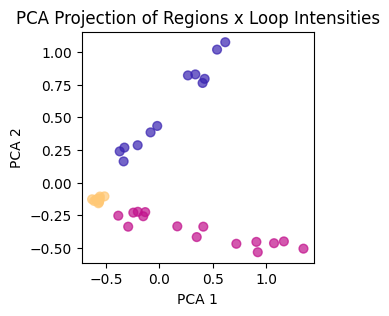

In [19]:
plt.figure(figsize=(3, 3))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            c=dots_colors,
            s=40, alpha=0.7)
plt.title('PCA Projection of Regions x Loop Intensities')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [20]:
from adjustText import adjust_text

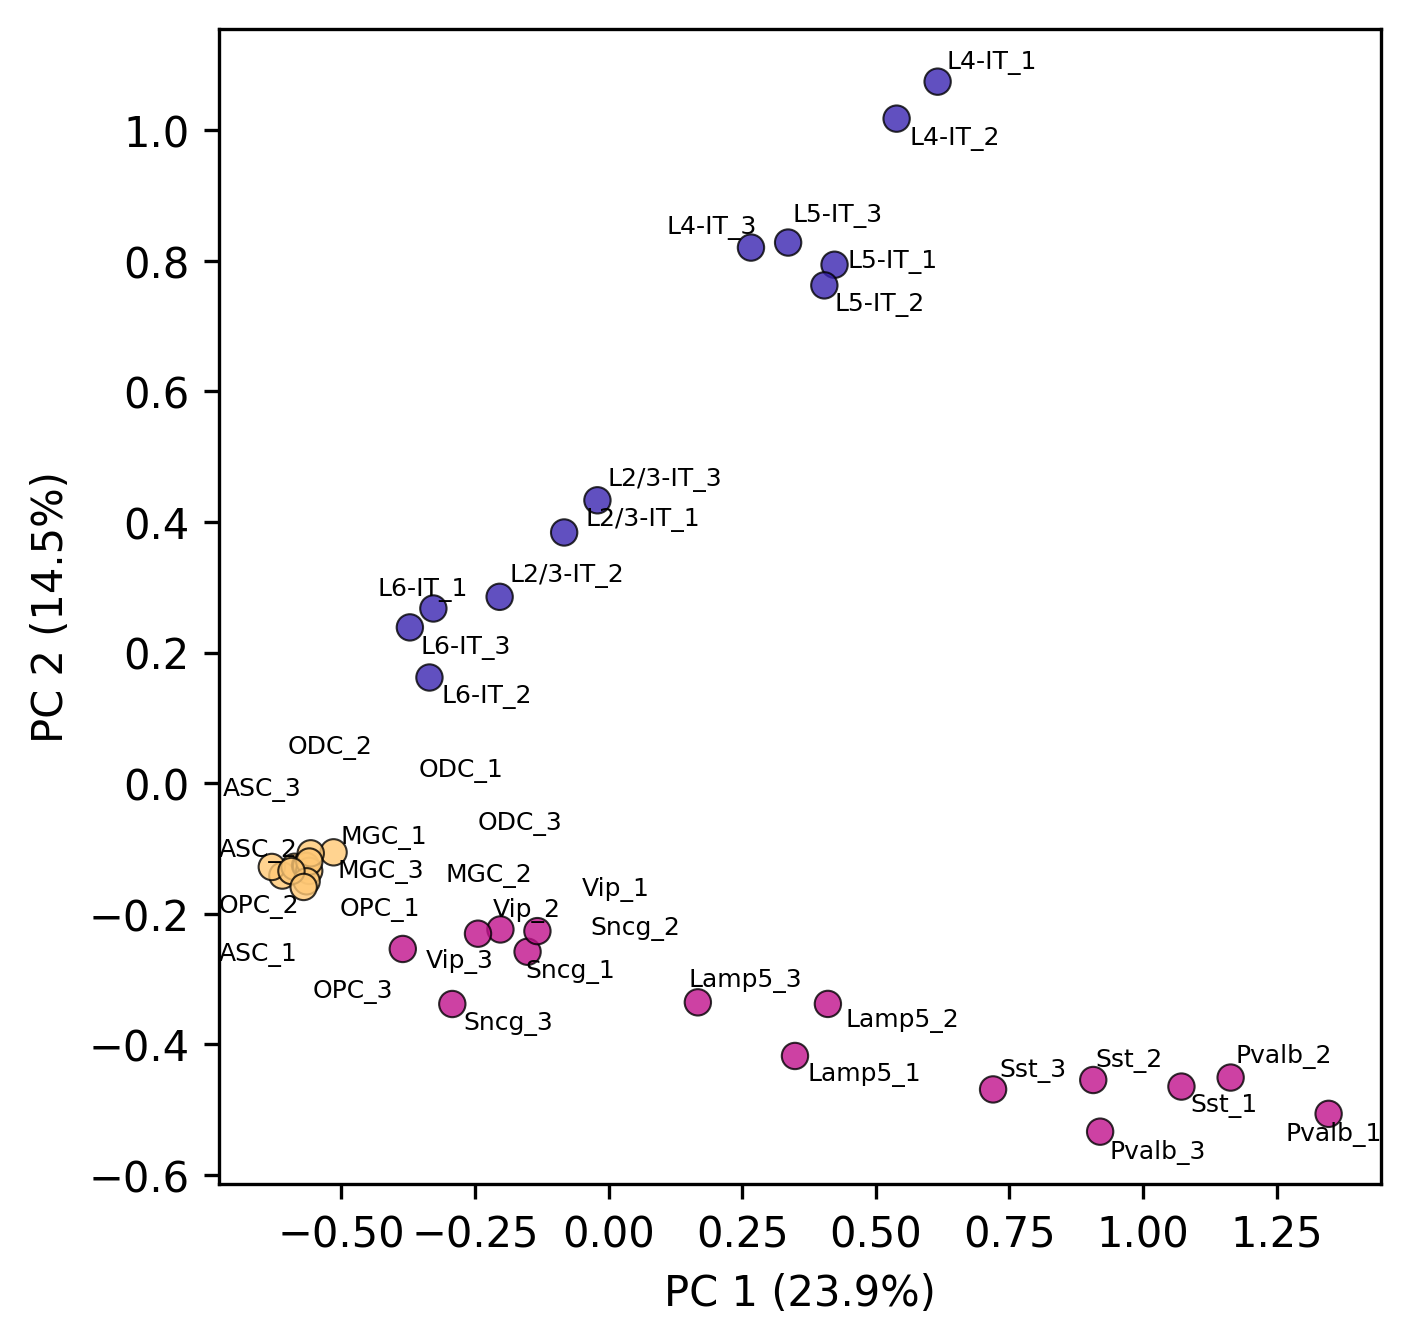

In [23]:
plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            c=dots_colors, edgecolor='k', linewidth=0.5,
            s=40, alpha=0.8)

texts = []
for i in range(len(pca_result)):
    x, y, t = pca_result[i, 0], pca_result[i, 1], maj_types[i]
    text = plt.text(x, y, t,
             fontsize=6, va='center')
    texts.append(text)
    
adjust_text(texts, expand=(1.3, 1.6))
# adjust_text(texts, expand=(1.3, 1.6), arrowprops=dict(arrowstyle='->', color='black', linewidth=0.1))

# Add explained variance to axis labels
plt.xlabel(f'PC 1 ({explained_variance[0]:.1f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]:.1f}%)')

# plt.savefig('imgs/FigS2c_PCA_by_CellType_by_Donor.pdf', bbox_inches='tight')
plt.show()

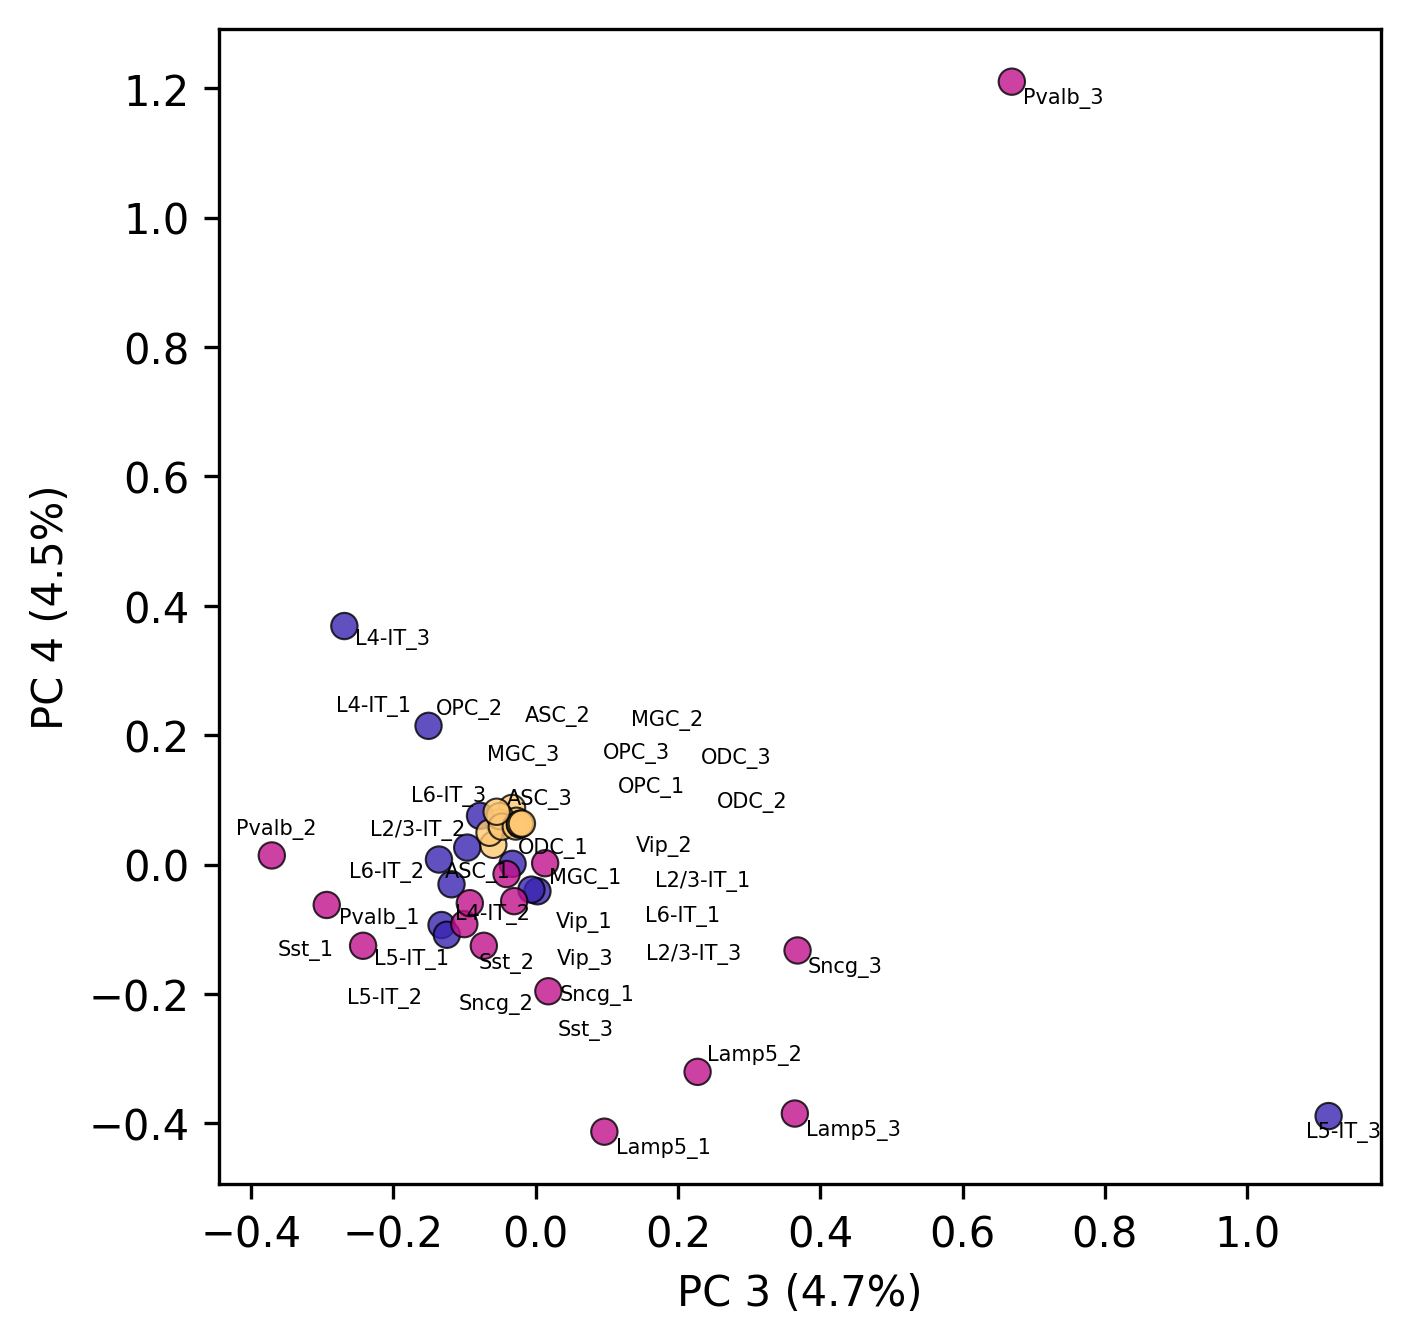

In [80]:
plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(pca_result[:, 2], pca_result[:, 3], 
            c=dots_colors, edgecolor='k', linewidth=0.5,
            s=40, alpha=0.8)

texts = []
for i in range(len(pca_result)):
    x, y, t = pca_result[i, 2], pca_result[i, 3], maj_types[i]
    text = plt.text(x, y, t,
             fontsize=5, ha=ha, va='center')
    texts.append(text)
    
adjust_text(texts, expand=(1.3, 1.6))
# adjust_text(texts, expand=(1.3, 1.6), arrowprops=dict(arrowstyle='->', color='black', linewidth=0.1))

# Add explained variance to axis labels
plt.xlabel(f'PC 3 ({explained_variance[2]:.1f}%)')
plt.ylabel(f'PC 4 ({explained_variance[3]:.1f}%)')

plt.show()